Inspirováno [https://github.com/xiaxilin/fvm_swes_1d]

In [2]:
from __future__ import absolute_import
import numpy as np
from six.moves import range

class Flux:
    def __init__(self, h = 0.0, q = 0.0):
        self.h = h
        self.q = q
        
class RiemannState:
    def __init__(self, L = 0.0, R = 0.0):
        self.L = L
        self.R = R

In [3]:
#HLL z Clawpacku
#aplikuje se na celé pole


def shallow_hll_1D(q_l,q_r,aux_l,aux_r,problem_data):
    r"""
    HLL shallow water solver ::
        W_1 = Q_hat - Q_l    s_1 = min(u_l-c_l,u_l+c_l,lambda_roe_1,lambda_roe_2)
        W_2 = Q_r - Q_hat    s_2 = max(u_r-c_r,u_r+c_r,lambda_roe_1,lambda_roe_2)
        Q_hat = ( f(q_r) - f(q_l) - s_2 * q_r + s_1 * q_l ) / (s_1 - s_2)
    *problem_data* should contain:
     - *g* - (float) Gravitational constant
    :Version: 1.0 (2009-02-05)
    """
    # Array shapes
    num_rp = q_l.shape[1]
    num_eqn = 2
    num_waves = 2

    # Output arrays
    wave = np.empty( (num_eqn, num_waves, num_rp) )
    s = np.empty( (num_waves, num_rp) )
    amdq = np.zeros( (num_eqn, num_rp) )
    apdq = np.zeros( (num_eqn, num_rp) )

    # Compute Roe and right and left speeds
    ubar = ( (q_l[1,:]/np.sqrt(q_l[0,:]) + q_r[1,:]/np.sqrt(q_r[0,:])) /
        (np.sqrt(q_l[0,:]) + np.sqrt(q_r[0,:])) )
    cbar = np.sqrt(0.5 * problem_data['grav'] * (q_l[0,:] + q_r[0,:]))
    u_r = q_r[1,:] / q_r[0,:]
    c_r = np.sqrt(problem_data['grav'] * q_r[0,:])
    u_l = q_l[1,:] / q_l[0,:]
    c_l = np.sqrt(problem_data['grav'] * q_l[0,:])

    # Compute Einfeldt speeds
    s_index = np.empty((4,num_rp))
    s_index[0,:] = ubar+cbar
    s_index[1,:] = ubar-cbar
    s_index[2,:] = u_l + c_l
    s_index[3,:] = u_l - c_l
    s[0,:] = np.min(s_index,axis=0)
    s_index[2,:] = u_r + c_r
    s_index[3,:] = u_r - c_r
    s[1,:] = np.max(s_index,axis=0)

    # Compute middle state
    q_hat = np.empty((2,num_rp))
    q_hat[0,:] = ((q_r[1,:] - q_l[1,:] - s[1,:] * q_r[0,:]
                            + s[0,:] * q_l[0,:]) / (s[0,:] - s[1,:]))
    q_hat[1,:] = ((q_r[1,:]**2/q_r[0,:] + 0.5 * problem_data['grav'] * q_r[0,:]**2
                - (q_l[1,:]**2/q_l[0,:] + 0.5 * problem_data['grav'] * q_l[0,:]**2)
                - s[1,:] * q_r[1,:] + s[0,:] * q_l[1,:]) / (s[0,:] - s[1,:]))

    # Compute each family of waves
    wave[:,0,:] = q_hat - q_l
    wave[:,1,:] = q_r - q_hat

    # Compute variations
    s_index = np.zeros((2,num_rp))
    for m in range(num_eqn):
        for mw in range(num_waves):
            s_index[0,:] = s[mw,:]
            amdq[m,:] += np.min(s_index,axis=0) * wave[m,mw,:]
            apdq[m,:] += np.max(s_index,axis=0) * wave[m,mw,:]

    return wave, s, amdq, apdq


In [7]:
problem_data = {'grav': 9.81,}

q_l =np.array([[1,1,1,.1,.1],[0,0,0,0,0]])
q_r =np.array([[1,1,.1,.1,.1],[0,0,0,0,0]])
wave, s, amdq, apdq = shallow_hll_1D(q_l,q_r,1,1,problem_data)

[[[ 0.          0.         -0.3832397   0.          0.        ]
  [ 0.          0.         -0.5167603   0.          0.        ]]

 [[-0.         -0.          0.89019743 -0.         -0.        ]
  [ 0.          0.         -0.89019743  0.          0.        ]]]


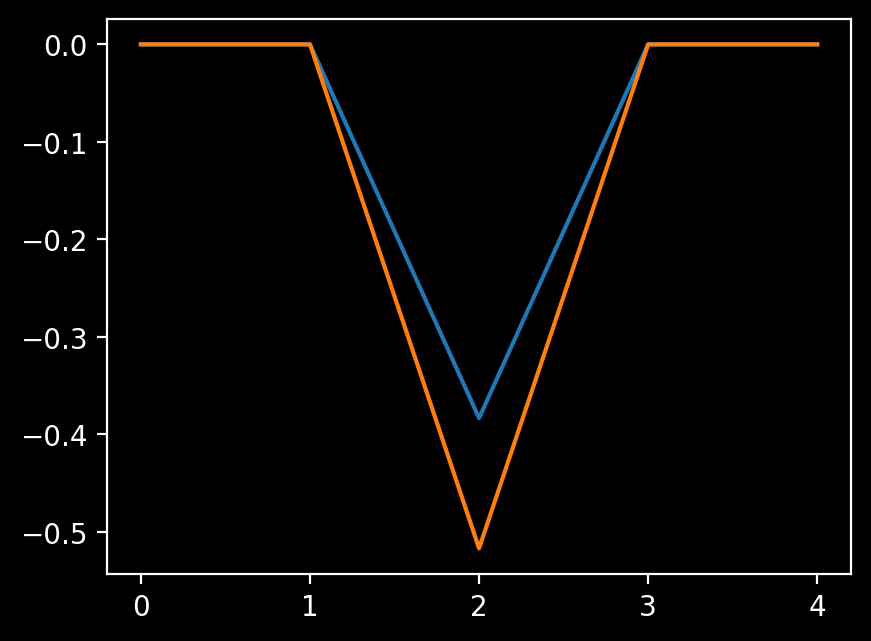

In [11]:
import matplotlib.pyplot as plt
print(wave)
plt.plot(wave[0,0,:])
plt.plot(wave[0,1,:])

In [8]:
problem_data['grav']

TypeError: 'set' object is not subscriptable

In [22]:
num_eqn = 2
num_waves = 2

#def shallow_roe_1D(q_l, q_r, aux_l, aux_r, problem_data):
def shallow_roe_1D(g, h_face, q_face): #q_l, q_r, aux_l, aux_r, problem_data):    
    r"""
    Roe shallow water solver in 1d::
        ubar = (sqrt(u_l) + sqrt(u_r)) / (sqrt(h_l) + sqrt(h_r))
        cbar = sqrt( 0.5 * g * (h_l + h_r))
        W_1 = |      1      |  s_1 = ubar - cbar
              | ubar - cbar |
        W_2 = |      1      |  s_1 = ubar + cbar
              | ubar + cbar |
        a1 = 0.5 * ( - delta_hu + (ubar + cbar) * delta_h ) / cbar
        a2 = 0.5 * (   delta_hu - (ubar - cbar) * delta_h ) / cbar
    *problem_data* should contain:
     - *g* - (float) Gravitational constant
     - *efix* - (bool) Boolean as to whether a entropy fix should be used, if
       not present, false is assumed
    :Version: 1.0 (2009-02-05)
    """
    aux_l = h_face.L
    aux_r = h_face.R
    q_l = q_face.L
    q_r = q_face.R
    problem_data = {
        'grav': g,
        'efix': False
    }
    #u_L = q_L/h_L
    #u_R = q_R/h_R

    
    # Array shapes
    num_rp = q_l.shape[1]

    # Output arrays
    wave = np.empty( (num_eqn, num_waves, num_rp) )
    s = np.zeros( (num_waves, num_rp) )
    amdq = np.zeros( (num_eqn, num_rp) )
    apdq = np.zeros( (num_eqn, num_rp) )

    # Compute roe-averaged quantities
    ubar = ( (q_l[1,:]/np.sqrt(q_l[0,:]) + q_r[1,:]/np.sqrt(q_r[0,:])) /
             (np.sqrt(q_l[0,:]) + np.sqrt(q_r[0,:])) )
    cbar = np.sqrt(0.5 * problem_data['grav'] * (q_l[0,:] + q_r[0,:]))

    # Compute Flux structure
    delta = q_r - q_l
    a1 = 0.5 * (-delta[1,:] + (ubar + cbar) * delta[0,:]) / cbar
    a2 = 0.5 * ( delta[1,:] - (ubar - cbar) * delta[0,:]) / cbar

    # Compute each family of waves
    wave[0,0,:] = a1
    wave[1,0,:] = a1 * (ubar - cbar)
    s[0,:] = ubar - cbar

    wave[0,1,:] = a2
    wave[1,1,:] = a2 * (ubar + cbar)
    s[1,:] = ubar + cbar

    if problem_data['efix']:
        raise NotImplementedError("Entropy fix has not been implemented.")
    else:
        s_index = np.zeros((2,num_rp))
        for m in range(num_eqn):
            for mw in range(num_waves):
                s_index[0,:] = s[mw,:]
                amdq[m,:] += np.min(s_index,axis=0) * wave[m,mw,:]
                apdq[m,:] += np.max(s_index,axis=0) * wave[m,mw,:]

    return wave, s, amdq, apdq

In [3]:
# Roe přímo z knížky



def shallow_water_roe(grav, h_face, q_face): #q_l, q_r, grav=1.):
    """
    Approximate Roe solver for the shallow water equations.
    """
    
    
    #h_L = h_face.L
    #h_R = h_face.R
    #q_L = q_face.L
    #q_R = q_face.R
    
    #h_l = q_l[0]
    h_l = h_face.L
    #hu_l = q_l[1]
    hu_l = q_face.L
    u_l = hu_l/h_l
    #h_r = q_r[0]
    h_r = h_face.R
    #hu_r = q_r[1]
    hu_r = q_face.R
    u_r = hu_r/h_r
    
    delta = np.array([h_face.R - h_face.L, q_face.R - q_face.L])#q_r - q_l
    
    # Roe averages
    h_hat = (h_r + h_l)/2.
    u_hat = (np.sqrt(h_r)*u_r + np.sqrt(h_l)*u_l) \
                / (np.sqrt(h_r) + np.sqrt(h_l))
    c_hat = np.sqrt(grav*h_hat)
    
    s1 = u_hat - c_hat
    s2 = u_hat + c_hat
    
    alpha1 = ( (u_hat+c_hat)*delta[0] - delta[1])/(2*c_hat)
    alpha2 = (-(u_hat-c_hat)*delta[0] + delta[1])/(2*c_hat)
    
    h_m = h_face.L + alpha1 #q_l[0] + alpha1
    hu_m = q_face.L + alpha1 * (u_hat - c_hat)
    q_m = np.array([h_m, hu_m])
    
    #states = np.column_stack([q_l,q_m,q_r])
    #speeds = [s1, s2]
    #wave_types = ['contact','contact']
    
    #def reval(xi):
    #    h_out  = (xi<s1)*h_l + (s1<=xi)*(xi<=s2)*h_m + (s2<xi)*h_r
    #    hu_out = (xi<s1)*hu_l + (s1<=xi)*(xi<=s2)*hu_m + (s2<xi)*hu_r
    #    return h_out, hu_out
    
    #return states, speeds, reval, wave_types
    return Flux(h_m, hu_m)
    

In [4]:
#hll přímo z knížky

def shallow_water_hll(grav, h_face, q_face): #(q_l, q_r, grav=1.):
    """
    HLLE approximate solver for the shallow water equations.
    """
    
    #h_l = q_l[0]
    h_l = h_face.L
    #hu_l = q_l[1]
    hu_l = q_face.L
    u_l = hu_l/h_l
    #h_r = q_r[0]
    h_r = h_face.R
    #hu_r = q_r[1]
    hu_r = q_face.R
    u_r = hu_r/h_r
    
    # Roe averages
    h_hat = (h_r + h_l)/2.
    u_hat = (np.sqrt(h_r)*u_r + np.sqrt(h_l)*u_l) / \
            (np.sqrt(h_r) + np.sqrt(h_l))
    c_hat = np.sqrt(grav*h_hat)

    lambda_1_l = u_l - np.sqrt(grav*h_l)
    lambda_2_r = u_r + np.sqrt(grav*h_r)
    
    s1 = min(lambda_1_l, u_hat - c_hat)
    s2 = max(lambda_2_r, u_hat + c_hat)
    
    h_m = (hu_r - hu_l - s2*h_r + s1*h_l)/(s1-s2)
    hu_m = (hu_r*u_r - hu_l*u_l + 0.5*grav*(h_r**2 - h_l**2) \
            - s2*hu_r + s1*hu_l)/(s1-s2)
    q_m = np.array([h_m, hu_m])
    
    #states = np.column_stack([q_l,q_m,q_r])
    speeds = [s1, s2]
    #wave_types = ['contact','contact']
    
    if 0 <= speeds[0]:
        h_flux = h_flux_L
        q_flux = q_flux_L
    elif  speeds[0] <= 0 and 0 <= speeds[1]:
        h_flux = h_flux_star
        q_flux = q_flux_star
    else:
        h_flux = h_flux_R
        q_flux = q_flux_R

    
    #def reval(xi):
    #    h_out  = (xi<s1)*h_l + (s1<=xi)*(xi<=s2)*h_m + (s2<xi)*h_r
    #    hu_out = (xi<s1)*hu_l + (s1<=xi)*(xi<=s2)*hu_m + (s2<xi)*hu_r
    #    return h_out, hu_out
    
    #return states, speeds, reval, wave_types
    return Flux(h_m, hu_m)

In [5]:
import math

#print 'This is a 1D python program for solving 1D shallow water equations with fvm'
#print 'author: xilin xia'
#print 'date: 21/10/2014'

#global arrays
h = [4.]*100+[1.0]*100#[1.0]*100+[0.1]*100
q = [0]*200
zbf = [0]*200
dhdt = [0]*200
dqdt = [0]*200
h_old = [0]*200
q_old = [0]*200
dhdt_old = [0]*200
dqdt_old = [0]*200

#total cell number
N = 200

#parameters
g = 9.81
x_ori = 0.0
dx = 0.05

#time controll
t = 0.0
dt = 0.001
tout = 1


class RiemannState:
    def __init__(self, L = 0.0, R = 0.0):
        self.L = L
        self.R = R

class Flux:
    def __init__(self, h = 0.0, q = 0.0):
        self.h = h
        self.q = q

#hllc riemann solver
def hllc(g, h_face, q_face):
    h_L = h_face.L
    h_R = h_face.R
    q_L = q_face.L
    q_R = q_face.R
    u_L = q_L/h_L
    u_R = q_R/h_R
    h_star_p = (math.sqrt(g*h_L) + math.sqrt(g*h_R)) / 2 + (u_L - u_R) / 4
    u_star = (u_L + u_R) / 2 + math.sqrt(g*h_L) - math.sqrt(g*h_R)
    h_star = (h_star_p*h_star_p) / g

    s_L = min(u_L - math.sqrt(g*h_L), u_star - math.sqrt(g*h_star))
    s_R = max(u_R + math.sqrt(g*h_R), u_star + math.sqrt(g*h_star))
 
    h_flux_L = q_L
    h_flux_R = q_R
    h_flux_star = (s_R*h_flux_L - s_L*h_flux_R + s_L*s_R*(h_R - h_L)) / (s_R - s_L)
    q_flux_L = q_L*u_L + g*h_L*h_L / 2.0
    q_flux_R = q_R*u_R + g*h_R*h_R / 2.0
    q_flux_star = (s_R*q_flux_L - s_L*q_flux_R + s_L*s_R*(q_R - q_L)) / (s_R - s_L)
 
    if 0 <= s_L:
        h_flux = h_flux_L
        q_flux = q_flux_L
    elif  s_L <= 0 and 0 <= s_R:
        h_flux = h_flux_star
        q_flux = q_flux_star
    else:
        h_flux = h_flux_R
        q_flux = q_flux_R

    return Flux(h_flux, q_flux)

#function to calculate dhdt and dqdt
def calcDDt(h,q,dhdt,dqdt,dx):
    N = len(q)
    for i in range(N):
        #west face
        if i == 0:
            h_west = RiemannState(h[i],h[i])
            q_west = RiemannState(q[i],q[i])
        else:
            h_west = RiemannState(h[i-1],h[i])
            q_west = RiemannState(q[i-1],q[i])
        #flux_west = shallow_roe_1D(g, h_west, q_west)    
        #flux_west = hllc(g, h_west, q_west) 
        #flux_west = shallow_water_roe(g, h_west, q_west) 
        flux_west = shallow_water_hll(g, h_west, q_west) 
        

        #east face
        if i == N - 1:
            h_east = RiemannState(h[i],h[i])
            q_east = RiemannState(q[i],q[i])
        else:
            h_east = RiemannState(h[i],h[i+1])
            q_east = RiemannState(q[i],q[i+1])
        #flux_east = shallow_roe_1D(g, h_east, q_east)
        #flux_east = hllc(g, h_east, q_east)
        #flux_east = shallow_water_roe(g, h_east, q_east)
        flux_east = shallow_water_hll(g, h_east, q_east)

        dhdt[i] = - (flux_east.h - flux_west.h)/dx
        dqdt[i] = - (flux_east.q - flux_west.q)/dx


#main function
while t < tout:
    #print(dt, t)
    #first Runge-Kutta
    calcDDt(h,q,dhdt,dqdt,dx)
    h_old = h[:]
    q_old = q[:]
    dhdt_old = dhdt[:]
    dqdt_old = dqdt[:]
    for i in range(N):
        h[i] = h[i] + dhdt[i]*dt
        q[i] = q[i] + dqdt[i]*dt
    #second Runge-Kutta
    calcDDt(h,q,dhdt,dqdt,dx)
    for i in range(N):
        h[i] = h_old[i] + (dhdt[i] + dhdt_old[i])*dt/2.0
        q[i] = q_old[i] + (dqdt[i] + dqdt_old[i])*dt/2.0

    t = t + dt

#output

#f = open('output.txt', 'w')

#for i in range(N):
#    print >> f, '%.6f %.6f %.6f' % (x_ori + i*dx, h[i], q[i])
#    print(x_ori + i*dx, h[i], q[i])
#f.close()

<ipython-input-4-88b2123878f9>:21: RuntimeWarning: invalid value encountered in sqrt
  u_hat = (np.sqrt(h_r)*u_r + np.sqrt(h_l)*u_l) / \
<ipython-input-4-88b2123878f9>:22: RuntimeWarning: invalid value encountered in sqrt
  (np.sqrt(h_r) + np.sqrt(h_l))
<ipython-input-4-88b2123878f9>:26: RuntimeWarning: invalid value encountered in sqrt
  lambda_2_r = u_r + np.sqrt(grav*h_r)
<ipython-input-4-88b2123878f9>:25: RuntimeWarning: invalid value encountered in sqrt
  lambda_1_l = u_l - np.sqrt(grav*h_l)


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

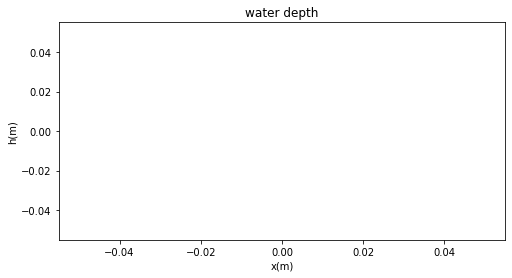

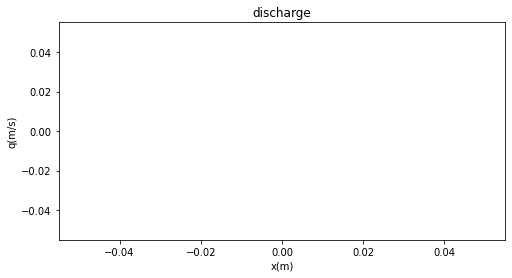

In [7]:
import matplotlib.pyplot as plt
import numpy as np

#data = np.loadtxt('output.txt')

x = np.zeros(200)
for i in range(N):
    x[i] = x_ori + i*dx
    
#h = data[:,1]
#q = data[:,2]
print(h)
plt.figure(figsize=(8,4))
plt.plot(x,h,color='blue',linewidth=2)
plt.xlabel('x(m)')
plt.ylabel('h(m)')
plt.title('water depth')
#plt.ylim(-0.2,1.2)
plt.show()


plt.figure(figsize=(8,4))
plt.plot(x,q,color='red',linewidth=2)
plt.xlabel('x(m)')
plt.ylabel('q(m/s)')
plt.title('discharge')
#plt.ylim(-0.2,1.2)
plt.show()